# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitaiton frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI, the NOAA Atlas 14 [volume](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) number, and durations of interest.

__Output__: A spreadsheet with tabs for each duration. Each tab contains a table for the given duration with area-averaged precipitation and confidence limits.

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
from hydromet import*

### Parameters: 

#### Papermill (site specific):

In [2]:
## Atlas 14 volume number:
volume = 2


## Vector polygon information (.geojson, .shp, or .gdb):
polygon = 'D01_2D_Domain.shp'


## Paths:
root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
datarepository_dir = root_dir/'DataRepository'
polygon_dir = inputs_dir/polygon
outputs_dir = root_dir/'Outputs'


## If geopandas cannot read the projection info, add proj4 string here
brute_force_projection = None

#### Global (project specific):

In [3]:
noaa_data_crs = {'init':'epsg:4326'} 

durations = ['06h', '12h', '24h', '04d'] 
dur_names = ['6hr', '12hr', '24hr', '96hr']

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'

verbose = True

### Load Atlas 14 volume code from json:

In [4]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: orb


## Read Vector Polygon:

### Load as a geodataframe:

In [5]:
gdf = gpd.GeoDataFrame.from_file(polygon_dir)

gdf.head(2)

,FID_2D_Dom,FID_CamRun,FID_1,Count,Length,Area,FID_CamR_1,FID_CamR_2,Id,FID_CamR_3,...,Area_1,FID_Camero,Id_1,Shape_Leng,Shape_Area,FID_Add_Ca,Id_12,Area_12,Area_12_13,geometry
0,0,0,0.0,88.0,216571.202923,1.644100e+09,-1,0,0,0,...,0.0,0,0,0.0,0.0,-1,0,53.617756,34315.363681,"POLYGON ((1250722.687626332 448421.3110747337,..."


### Add filtering if desired

In [6]:
filter_field = 'FID_2D_Dom'        # Attribute with in the vector polygon used for data selection
select_data = 0                    # Value within the filter_field used for data selection
gdf_slice_column = 'FID_2D_Dom'    # Column within the vector polygon to plot

### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [7]:
print('Original Coordinate Reference System:', gdf.crs)
with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))

Original Coordinate Reference System: {'init': 'epsg:2248'}
Error: Setting projection as +proj=lcc +lat_1=39.45 +lat_2=38.3 +lat_0=37.66666666666666 +lon_0=-77 +x_0=399999.9998983998 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs


### Extract the area of interest, reproject, and plot:

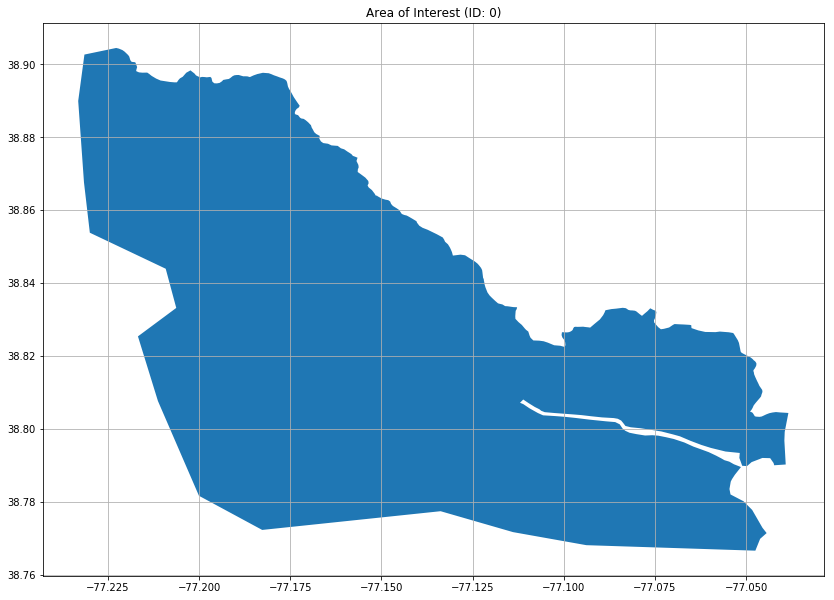

In [8]:
gdf = gdf.loc[gdf[filter_field] == select_data].copy()
    
gdf.crs = vector_crs_prj

geo_df = gdf.to_crs(crs = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, gdf_slice_column)

## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [9]:
noaa_url = 'ftp://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    if verbose: print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

30 files found for 06h
30 files found for 12h
30 files found for 24h
30 files found for 04d


### Iterate through zip files and build a table:

In [10]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 orb1000yr06ha.zip
1 orb1000yr06hal.zip
2 orb1000yr06hau.zip
3 orb100yr06ha.zip
4 orb100yr06hal.zip
5 orb100yr06hau.zip
6 orb10yr06ha.zip
7 orb10yr06hal.zip
8 orb10yr06hau.zip
9 orb1yr06ha.zip
10 orb1yr06hal.zip
11 orb1yr06hau.zip
12 orb200yr06ha.zip
13 orb200yr06hal.zip
14 orb200yr06hau.zip
15 orb25yr06ha.zip
16 orb25yr06hal.zip
17 orb25yr06hau.zip
18 orb2yr06ha.zip
19 orb2yr06hal.zip
20 orb2yr06hau.zip
21 orb500yr06ha.zip
22 orb500yr06hal.zip
23 orb500yr06hau.zip
24 orb50yr06ha.zip
25 orb50yr06hal.zip
26 orb50yr06hau.zip
27 orb5yr06ha.zip
28 orb5yr06hal.zip
29 orb5yr06hau.zip
30 orb1000yr12ha.zip
31 orb1000yr12hal.zip
32 orb1000yr12hau.zip
33 orb100yr12ha.zip
34 orb100yr12hal.zip
35 orb100yr12hau.zip
36 orb10yr12ha.zip
37 orb10yr12hal.zip
38 orb10yr12hau.zip
39 orb1yr12ha.zip
40 orb1yr12hal.zip
41 orb1yr12hau.zip
42 orb200yr12ha.zip
43 orb200yr12hal.zip
44 orb200yr12hau.zip
45 orb25yr12ha.zip
46 orb25yr12hal.zip
47 orb25yr12hau.zip
48 orb2yr12ha.zip
49 orb2yr12hal.zip
50 orb2yr12hau

,TR,duration,region,statistic,value
0,1000,06h,orb,Expected Value,8.027368
1,1000,06h,orb,Lower (90%),6.731976
2,1000,06h,orb,Upper (90%),9.059344
3,100,06h,orb,Expected Value,5.343378
4,100,06h,orb,Lower (90%),4.675086


None


### Save the results to an Excel Workbook:

#### Create an outputs directory:

In [11]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

#### Save to Excel:

In [12]:
writer = pd.ExcelWriter(outputs_dir/'PrecipTable_{}.xlsx'.format(select_data))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
    print(table)
    
writer.save()

      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           1.864675     1.695129     2.069675
2           2.260435     2.050273     2.504780
5           2.855522     2.579981     3.163306
10          3.343483     3.007182     3.701110
25          4.065177     3.623344     4.499579
50          4.678502     4.132215     5.181297
100         5.343378     4.675086     5.928244
200         6.064033     5.248450     6.753498
500         7.128148     6.067493     7.999952
1000        8.027368     6.731976     9.059344
      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           2.258593     2.036847     2.527502
2           2.727459     2.457249     3.051732
5           3.462976     3.112349     3.873675
10          4.092660     3.656445     4.572708
25          5.050512     4.465919     5.636005
50          5.888914     5.152517     6.574670
100         6.821081     5.893919     7.632474
200         7

---